In [1]:
# DM2 de statistiques

# Exercice 1

In [2]:
# Import des librairies nécessaires
from __future__ import division
import pandas as pd #  Pour lire le fichier et manipuler les données
from sklearn import linear_model #  Pour réaliser la régression linéaire
import matplotlib.pyplot as plt #  Pour les graphs
import numpy as np #  Pour manipuler les matrices
import seaborn as sns
from sklearn import preprocessing #  Pour le centrage-réduction
from sklearn.cross_validation import cross_val_score #  Pour le calcul des scores des modèles
import numpy.random as npr  #  Pour le tirage avec remise lors du bootstrap
from numpy.linalg import norm
from multiprocessing import Pool # Pour gagner du temps lors des simulations monte carlo
np.set_printoptions(precision = 8)
import scipy 

1) Génération d'un échantillon suivant une loi béta

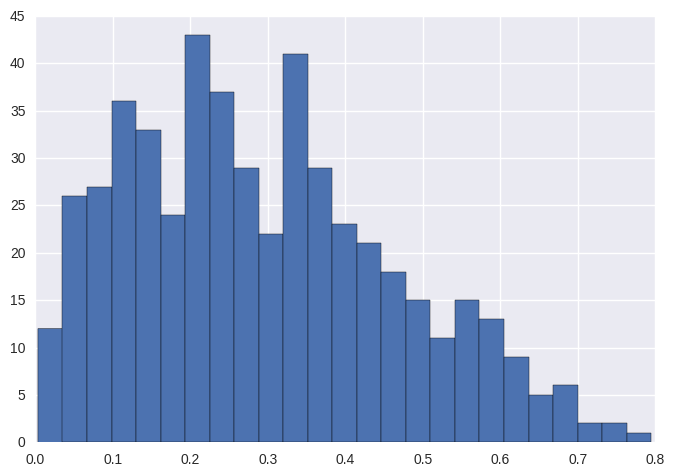

[ 0.28147427  0.28841805]


In [28]:
np.random.seed(1) # Seed pour la reproductibilité
n = 500 # 500 individus dans l'échantillon
a = 2 # Alpha
b = 5 # Beta 
X = np.random.beta(a, b, n)

plt.hist(X, bins = 25) # On trace un histogramme avec 25 bins
plt.show()
sample = []
x = np.random.beta(a, b, n)
y = np.random.beta(a, b, n)
v = [x, y]
means = np.mean(v, axis = 1)
print(means) # Vecteur moyen

2) Calculer 500 estimateurs bootstrap de la moyenne

[ 0.28147295  0.28838189]


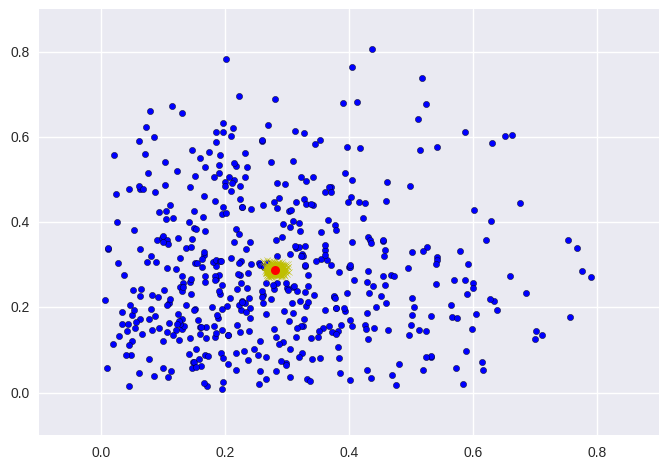

In [29]:
def bootstrap_mean(original_sample, length): # Calcule la moyenne bootstrap
    newmem = []
    for _ in range(length):
        selector = np.random.randint(length, size = length)
        new = [original_sample[0][selector], original_sample[1][selector]]
        x_mean = np.mean(new[0])
        y_mean = np.mean(new[1])
        v_mean = [x_mean, y_mean]
        newmem.append(v_mean)
    return newmem

B = 500
bootstrap_of_means = bootstrap_mean(v, B)
boot_mean = np.mean(bootstrap_of_means, axis = 0)
print(boot_mean) # Le vecteur moyen est proche du précédent 
fig = plt.figure()
ax = fig.add_subplot(111)
x = [_ for _ in v[0]]
y = [_ for _ in v[1]]
b_x = [x[0] for x in bootstrap_of_means]
b_y = [x[1] for x in bootstrap_of_means]


ax.scatter(x, y) # observations initiales en bleu
ax.scatter(b_x, b_y, marker = 'x',  color = 'y') # moyennes bootstrap en jaune
ax.scatter(means[0],means[1], color = 'r', linewidths = 2) # moyenne réelle en rouge
plt.show()


3) Donner l'estimateur bootstrap du biais et de la variance

In [30]:
# Calcul de l'estimateur bootstrap de la moyenne
bias = np.mean(np.subtract(bootstrap_of_means, means), axis = 0)
print("biais : ",bias,"\n") 
A = np.subtract(bootstrap_of_means, boot_mean)
print(A.shape)
A_2 = np.dot(A.transpose(), A)
varboot = B ** - 1 * A_2 
print("Estimateur bootstrap de la variance :\n ",varboot,"\n") 


biais :  [ -1.31831966e-06  -3.61570666e-05] 

(500, 2)
Estimateur bootstrap de la variance :
  [[  5.78498848e-05   1.94214840e-06]
 [  1.94214840e-06   5.26124915e-05]] 



4) Calculer l'estimateur jackknife du biais et de la variance

In [31]:
def jackknife_mean(original_sample, length):
    mem = []
    for i in range(length):
        temp_x = np.concatenate((original_sample[0][:i], original_sample[0][i + 1:]), axis = 0)
        temp_y = np.concatenate((original_sample[1][:i], original_sample[1][i + 1:]), axis = 0)
        means = [np.mean(temp_x), np.mean(temp_y)]
        mem.append(means)
    return mem

length = 500
jackknife_means = jackknife_mean(v, length) # on obtient le vecteur de l'estimation JK des moyennes
mean_j_means = np.mean(jackknife_means, axis = 0)
print("vecteur moyen :", mean_j_means,"\n") # 0.28183458  0.28851459 estimateur jackknife de la moyenne
bias_jk = float(length - 1) / length * np.sum(np.subtract(jackknife_means, means), axis = 0)
print("biais : ", bias_jk,"\n") # 5.92781380e-15   1.92792449e-14 estimateur jknife du biais
N = jackknife_means - mean_j_means # On split la formule pour plus de lisibilité
O = np.dot(N.transpose(), N)
cov_j = (length -1) / length * O
print("Matrice de covariance des estimateurs jackknife de la moyenne \n", cov_j,"\n")
real_cov = np.cov(v) / length
print("Matrice de covariance réelle de la moyenne sur les 500 vecteurs\n",real_cov,"\n")
print("Est-ce que ces deux covariances sont proches ?\n", np.isclose(cov_j, real_cov))

vecteur moyen : [ 0.28147427  0.28841805] 

biais :  [  5.92781380e-15   1.92792449e-14] 

Matrice de covariance des estimateurs jackknife de la moyenne 
 [[  5.42022097e-05   3.23498520e-07]
 [  3.23498520e-07   5.52020457e-05]] 

Matrice de covariance réelle de la moyenne sur les 500 vecteurs
 [[  5.42022097e-05   3.23498520e-07]
 [  3.23498520e-07   5.52020457e-05]] 

Est-ce que ces deux covariances sont proches ?
 [[ True  True]
 [ True  True]]


5) Donner la vraie covariance de l'estimateur de la moyenne, comparer les 3 covariances précédentes avec une norme l1.

On connait l'espérance pour une loi beta : E(x) = $\scriptsize α/(α+β)$, la variance est donnée par $\scriptsize V(x) = αβ / (α+β+1)(α+β)²$
Nous pouvons calculer la vraie variance de l'estimateur de la moyenne en utilisant le fait que : $\scriptsize Var(µ) = 1/n * Var (X_{1}, X_{2}) = 1 / n *  \left( \begin{array}{cc}
Var(X_{1}) & Cov(X_{1},X_{2})  \\
Cov(X_{1},X_{2}) & Var(X_{2})\end{array} \right)$ (on note au passage l'erreur dans l'énoncé...)

$\scriptsize Var(X_{1}) = Var(X_{2}) = 5 / 196$, 
$\scriptsize Cov(X_{1}, X_{2}) = 0$ car les deux variables sont indépendantes donc

$\scriptsize Var(µ) = 1 / n *  \left( \begin{array}{cc}
Var(X_{1}) & 0)  \\
0 & Var(X_{2})\end{array} \right) = \left( \begin{array}{cc}
5 / 98000 & 0  \\
0 & 5/98000\end{array} \right)$ 

In [32]:
#l1 norm for Bootstrap

var_mu = np.array([[5.0 / 98000, 0],[0, 5.0/98000]])
distBoot = norm(varboot[0][0] - var_mu[0][0]) + norm(varboot[0][1] - var_mu[0][1]) +\
norm((varboot[1][1] - var_mu[1][1]))
print(distBoot,"\n")# 1.03637083305e-05

#l1 norm for jackknife
var_mu = np.array([[5.0 / 98000, 0],[0, 5.0/98000]])
distJack = norm(cov_j[0][0] - var_mu[0][0]) + norm(cov_j[0][1] - var_mu[0][1]) +\
norm((cov_j[1][1] - var_mu[1][1]))
print(distJack)


1.03637083305e-05 

7.68693758299e-06


Le jackknife est plus performant en tant qu'estimateur de la moyenne puisque la distance à la vraie variance est plus faible.

# Exercice 2

6) Générer 300 vecteurs indépendants X avec 2 composants dépendants ..

In [10]:
s = 300
npr.seed(1)
U = np.random.uniform(-0.1, 0.1, s)
X_1 = np.random.uniform(0, 1, s)
X_2 = X_1 + U # X₂ est la somme de deux variables indépendantes 


7) Donner le coefficient de corrélation théorique et le coefficient estimé

Le coefficient de corrélation théorique est donné par : $\scriptsize Cov(X_₁, X_₂) / σ₁σ₂$ 

$\\$Nous avons $\scriptsize Cov(X_₁,X_₂) = E[X_₁] + E[X_₁, U₁] - E[X_₁]² - E[X_₁]E[X_₁]$


Par la formule de Huygens, nous obtenons :
$\scriptsize Cov(X_₁,X_₂) = Var(X_₁)$

Pour la loi uniforme que suit X₁, nous avons $\scriptsize var(X₁) = 1 / 12$

Et $\scriptsize Var(X_₂) = Var(X_₁) + Var(U_₁)$, car X₁ et U₁ sont indépendants.

Donc $\scriptsize Corr(X_₁, U₁) = \sqrt(1/12) / \sqrt(1/12 + 0,01/3)$ 

In [12]:
corr_th = np.sqrt(1.0 / 12) / np.sqrt(1.0 / 12 + 0.01 / 3)
print("La corrélation théorique vaut donc : ", corr_th)
corr_est = np.corrcoef(X_1, X_2)[0][1]
print("La corrélation empirique vaut : ", corr_est)

La corrélation théorique vaut donc :  0.980580675691
La corrélation empirique vaut :  0.979619926577


La corrélation calculée par Numpy est assez proche de la corrélation théorique.

8) Donner un intervalle de confiance à 5% pour le coefficient de correlation avec 500 replicas

In [78]:
def bootstrap_corr(original_sample, length): # Retourne le vecteur bootstrap des correlations
    newmem = []
    for _ in range(length):
        selector = np.random.randint(len(original_sample[0]), size = length)
        new = [original_sample[0][selector], original_sample[1][selector]]
        v_corr = np.corrcoef(new[0], new[1])
        newmem.append(v_corr[0][1])
    return sorted(newmem)# Pour avoir les percentiles correctement, il faut un vecteur trié

size = 500
sample_uni = [X_1, X_2]
b_vector_corr = bootstrap_corr(sample_uni, size)

def basic_bootstrap_ic_5(param, boot_vect): # Retourne l'intervalle de confiance bootstrap à 5% du paramètre
    α = 5.0
    norm = np.sqrt(len(sample_uni))
    std_corr = np.subtract(boot_vect, param) * norm
    ksi1 = np.percentile(std_corr, 100. - α/2)
    ksi2 = np.percentile(std_corr, α/2)    
    return [param - ksi1 / norm, param - ksi2 / norm]

ci_bb = basic_bootstrap_ic_5(corr_est, b_vector_corr)


print("L\'intervalle de confiance à 5% de l'estimateur bootstrap basique des corrélations est: "+ "%.8f"  
      % ci_bb[0],  "%.8f" % ci_bb[1])

L'intervalle de confiance à 5% de l'estimateur bootstrap basique des corrélations est: 0.97744907 0.98189158


9) Calculer l'intervalle de confiance à 5% de l'estimateur bootstrap percentile pour le coefficient de corrélation.

In [14]:
def percentile_bootstrap_ic_5(boot_vector): # Retourne l'intervalle de confiance à 5% du paramètre estimé
    α = 5.0
    i1 = np.percentile(boot_vector, α / 2.0)
    i2 = np.percentile(boot_vector, 100 - α / 2.0)
    return [i1, i2]

ic_5_p_boot = percentile_bootstrap_ic_5(b_vector_corr)

print("Intervalle de confiance à 5% de l\' estimateur bootstrap percentile : ", ic_5_p_boot[0], ic_5_p_boot[1])

Intervalle de confiance à 5% de l' estimateur bootstrap percentile :  0.977303147819 0.981807119503


10) Calculer l'intervalle de confiance à 5% de l'estimateur bootstrap asymptotique du coefficient de corrélation

In [15]:
# Fonction qui calcule la variance de sqrt(n) * (estimation bootstrap - corrélation réelle)
def ic_asymp_5(original_sample, boot_vect, param):
    norm = np.sqrt(len(original_sample))
    std_corr = list(np.subtract(boot_vect, param) * norm)
    jk_var = np.mean([np.sqrt(np.var(std_corr[:i] + std_corr[i+1:])) for i in range(len(original_sample))])
    ksi = 1.96
    return [param - (jk_var * ksi) / norm, param + (jk_var * ksi) / norm]

ic_asymptotic = ic_asymp_5(sample_uni, b_vector_corr, corr_th)


print("Intervalle de confiance à 5 % de l'estimateur du bootstrap asymptotique : ", "%.8f" % ic_asymptotic[0],
      "%.8f" % ic_asymptotic[1])

Intervalle de confiance à 5 % de l'estimateur du bootstrap asymptotique :  0.97826653 0.98289482


11) Estimer la probabilité de couverture des 3 méthodes précédentes.

In [16]:
# Fonction de génération des échantillons X_1 et X_2
def populate(sample_size):
    return [(u, u + npr.uniform(-.1,.1)) for u in npr.uniform(0, 1, size = sample_size)]

# Fonction de génération du vecteur bootstrap des correlations
def boot_corr(original_sample, bootstrap_length):
    n = len(original_sample)
    return [np.corrcoef(np.transpose([original_sample[i] for i in npr.randint(0,n,n)]))[0,1]
            for _ in range(bootstrap_length)]

# Fonction qui renvoie 1,0 si le paramètre est/n'est pas dans l'intervalle bootstrap basique à 5% 
def param_in_ic_bb(boot_vect, param_est, param_th):
    ic_5_bb = basic_bootstrap_ic_5(param_est, boot_vect)
    return 1 if ic_5_bb[0] <= param_th <= ic_5_bb[1] else 0

# Fonction qui renvoie 1,0 si le paramètre est/n'est pas dans l'intervalle bootstrap percentile à 5% 
def param_in_ic_pb(boot_vect, param_est, param_th):
    ic_5_pb = percentile_bootstrap_ic_5(boot_vect)
    return 1 if ic_5_pb[0] <= param_th <= ic_5_pb[1] else 0

# Fonction qui renvoie 1,0 si le paramètre est/n'est pas dans l'intervalle bootstrap asymptotique à 5% 
def param_in_ic_ab(original_sample, boot_vect, param_est, param_th):
    ic_5_asymp = ic_asymp_5(original_sample, boot_vect, param_est)
    return 1 if ic_5_asymp[0] <= param_th <=  ic_5_asymp[1] else 0

real_corr = 1/(np.sqrt(1.04))  # Correlation réelle pour X

# Fonction qui va vérifier si le paramètre est dans les 3 types d'intervalles définis ci-dessus
def check_real_val_in_ic(size_boot_vect):
    X = populate(300)
    corr_est = np.corrcoef(np.transpose(X))[0,1]
    vecteur_bootstrap = boot_corr(X, size_boot_vect) # Génération des estimations bootstrap de la correlation
    return [param_in_ic_bb(vecteur_bootstrap, corr_est, real_corr), 
            param_in_ic_pb(vecteur_bootstrap, corr_est, real_corr),
           param_in_ic_ab(X, vecteur_bootstrap, corr_est, real_corr)]

# Fonction qui effectue les simulations Monte-Carlo    
def param_coverage(num_simulation, size_vect_boot):
# Pour réduire le temps d'exécution on va calculer les simulations en parallèle
    with Pool() as pool:
        np.random.seed()
        coverage = 100 * np.sum(pool.map(check_real_val_in_ic,(size_vect_boot,)*num_simulation), axis=0) / num_simulation   
    return coverage

test_coverage_proba = param_coverage(2000, 500)
print(test_coverage_proba)

[ 94.3  94.7  95.4]


12) Dessiner les différentes probabilités de couverture pour une taille d'échantillon n = 30, 50, 100, 300

In [ ]:
#Plot des performances des estimateurs
sample_sizes = [30, 50, 100, 300]
coverages = []
for size in sample_sizes:
    coverages.append(list(param_coverage(size, 500)))

fig, ax = plt.subplots()
ax.bar([0,5,10,15], [x[0] for x in coverages],1 , color = 'blue', label = 'Basic')
ax.bar([1,6,11,16], [x[1] for x in coverages],1 , color = 'red', label = 'Percentile')
ax.bar([2,7,12,17], [x[2] for x in coverages],1 , color = 'green', label = 'Asymptotic')
ax.set_xticklabels(['n=30','n=50','n=100','n=300'])
ax.set_xticks([1.5, 6.5, 11.5, 16.5])
ax.set_ylim = 100
plt.legend(loc = 2)
plt.show()




# Exercice 3

In [83]:
# Importation des données

url = 'auto-mpg.data-original'
cols = ['mpg', 'cylinders', 'displacement', 'horsepower',
          'weight', 'acceleration', 'model year', 'origin', 'car name']
data = pd.read_csv(url, sep=r"\s+", names=cols, na_values='NA')
data = data.dropna(axis=0, how='any')
data.drop('origin', 1 , inplace = True )
data.drop('car name', 1, inplace = True)
data.reset_index(inplace = True)
y = data['mpg']# La variable à prédire
data.drop('mpg', 1, inplace = True)
print(data.columns)# Nos variables explicatives nettoyées


Index(['index', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year'],
      dtype='object')


Nous allons calculer l'estimateur des moindres carrés en utilisant la librairie Scikit-Learn

(392, 6)
Ordonnée à l'origine :  -14.2584729657
Coefficients de l'estimateur des moindres carrés :  [-0.11674629  0.01256287 -0.01368534 -0.00713034  0.16949946  0.74000028]


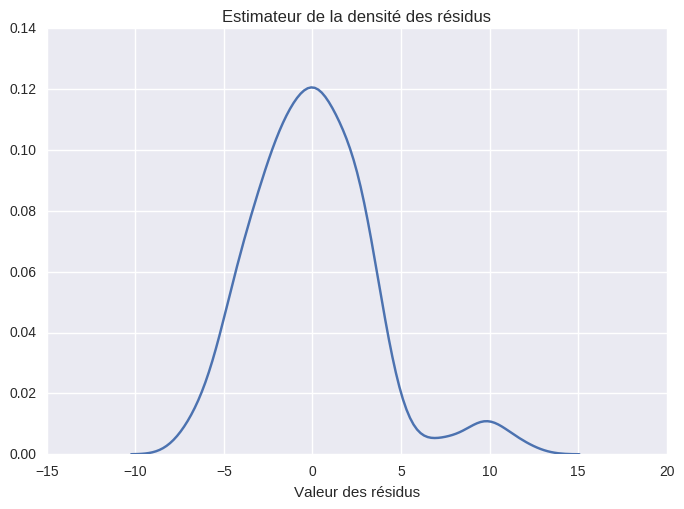

In [96]:
# Calcul de l'estimateur des moindres carrés aprés centrage-réduction de X
skl_linmod = linear_model.LinearRegression()
# scaler = preprocessing.StandardScaler().fit(data)
# X = scaler.transform(data)
X = data.ix[:,1:7]
print(X.shape)
skl_linmod.fit(X, y)
print("Ordonnée à l\'origine : ", skl_linmod.intercept_)
print("Coefficients de l\'estimateur des moindres carrés : ", skl_linmod.coef_)
residuals = y -  skl_linmod.predict(X)
sns.kdeplot(residuals)
plt.title("Estimateur de la densité des résidus")
plt.xlabel("Valeur des résidus")
plt.show()

14) Donner une intervalle de confiance à 5% du coefficient θ₁ sous hypothèse d'homoscedasticité.

In [97]:
rank = np.linalg.matrix_rank(X)
MSE = (np.linalg.norm(residuals) ** 2 / (len(X) - rank)) # Estimateur sans biais de la variance
#Calcul des quantiles de la loi t de student
Q5t = scipy.stats.t.ppf(1 - 0.05 / 2, len(X) - rank)
D = np.sqrt(MSE) * np.sqrt(np.linalg.inv(np.dot(np.transpose(X),X))[0,0])
IC5t = [skl_linmod.coef_[0] - Q5t * D, skl_linmod.coef_[0] + Q5t * D]
print("L\'intervalle de confiance vaut : ",IC5t)
#L\'intervalle de confiance si X est normalisé vaut : [-1.6728938835591498, 0.54899396165037939]

L'intervalle de confiance vaut :  [-0.75323907118452138, 0.51974648314949978]


15) Implémenter la méthode bootstrap pour les résidus et tracer les graphs

(200, 392)


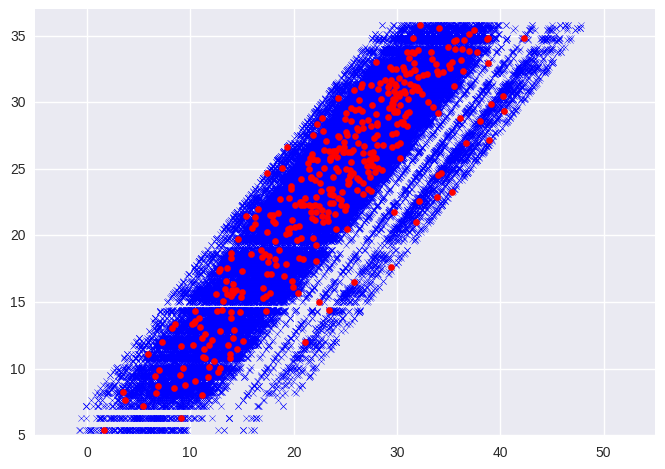

In [98]:
boot_res_size = 200
n = len(X)
prediction = skl_linmod.predict(X)
yhatstar = [[residuals[i] for i in npr.randint(0,n, n)] for _ in range(boot_res_size)] +  prediction
print(yhatstar.shape) # Notre vecteur bootstrap des residus de l'estimateur des moindres carrés
fig = plt.figure()
ax = fig.add_subplot(111)
for y in yhatstar:
    ax.scatter(y, prediction, color = 'b', marker = 'x')
ax.scatter(y, prediction, color = 'r')
ax.set_ylim(5,37)
ax.set_xlim(-5,55)
plt.show()


    

Les résidus obtenus avec la méthode des moindres carrés sont bien "contenus" dans les résidus estimés avec le basic bootstrap

16) Calculer un intervalle de confiance bootstrap basique à 5% pour theta1

In [99]:
coefs_b_vector = []
clf = linear_model.LinearRegression()
for yhs in yhatstar:
    clf.fit(X, yhs)
    coefs_b_vector.append(clf.coef_[0])
basic_boot_ic_theta = basic_bootstrap_ic_5(skl_linmod.coef_[0], coefs_b_vector)
print("Intervalle de confiance à 5 % de l'estimateur du bootstrap basique pour theta1 : ", basic_boot_ic_theta[0],"\n",
      basic_boot_ic_theta[1])


Intervalle de confiance à 5 % de l'estimateur du bootstrap basique pour theta1 :  -0.828806315446 
 0.479588406879


17) Calculer les intervalles de confiance pour tous les coefficients et grapher les coefficients avec leur intervalle de confiance selon les différentes méthodes.

************************************************************************************************************************ 
Intervalles de confiance basic bootstrap

Paramètre de la régression linéaire :  [-0.11674629  0.01256287 -0.01368534 -0.00713034  0.16949946  0.74000028] 

Intervalles de confiances basic bootstrap pour chacun des 6 coefficients : 
[-0.5449292130393405, 0.046836522472050293]
[0.011229588433105602, 0.022529074334253149]
[-0.019479794206224709, 0.00020221637164221859]
[-0.0080548379977903456, -0.007084529039700198]
[0.14265822143350909, 0.29967704828012365]
[0.72709171569724496, 0.81437227899306075]
************************************************************************************************************************ Intervalles de confiance percentile bootstrap
[-0.73920081004716209, 0.46946021769357199]
[-0.0011663297475599246, 0.027538429851102372]
[-0.037147546888794181, 0.012380017901784536]
[-0.0084323684576539781, -0.0058472368930736806]
[-0.04814290863906703

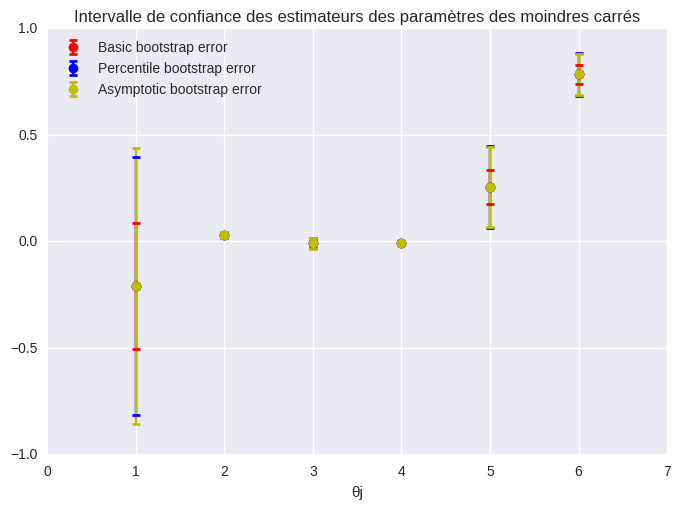

In [193]:
def getTheta(x, yi):
    clf_i = linear_model.LinearRegression()
    clf_i.fit(x, yi)
    return clf_i.coef_

yhatstar = [[residuals[i] for i in npr.randint(0,n, n)] for _ in range(boot_res_size)] +  prediction
all_theta_chap_star = list(map(lambda yichap : getTheta(X, yichap), yhatstar)) # On génére 200 vecteur de coefficients de
# régression pour calculer nos intervalles de confiance bootstrap (200 x 6)
print("*" * 120,"\nIntervalles de confiance basic bootstrap\n")
norm = np.sqrt(len(X))
thetas = skl_linmod.coef_
α = 5.0

def ic_bb5(theta):
    r = range(len(np.transpose(all_theta_chap_star)))
    sub = [norm * (all_theta_chap_star[k][int(np.where(thetas == theta)[0])] - theta) for k in r]
    ksi1 = np.percentile(sub, 100. - α/2)
    ksi2 = np.percentile(sub, α/2)
    return [theta - ksi1 / norm, theta - ksi2 / norm]

# On génére les intervalles de confiance à 5% de bootstrap basique
ICbb = []
for theta in thetas:
    ICbb.append(ic_bb5(theta))
print("Paramètre de la régression linéaire : ",thetas,"\n")
print("Intervalles de confiances basic bootstrap pour chacun des 6 coefficients : ")
for ic in ICbb: # L'intervalle de confiance basique bootstrap à 5% pour chaque coefficient de la régression linéaire
    print(ic)

print("*" * 120,"Intervalles de confiance percentile bootstrap")
    
def pb_ic_5(boot_vector): # Retourne l'intervalle de confiance percentile bootstrap à 5% du paramètre estimé
    α = 5.0
    i1 = np.percentile(boot_vector, α / 2.0)
    i2 = np.percentile(boot_vector, 100 - α / 2.0)
    return [i1, i2]


ICpb = []
for theta_chap_star in np.transpose(all_theta_chap_star):# On transpose pour avoir la matrice 6 colonnes 200 lignes
    ICpb.append(pb_ic_5(theta_chap_star))               # des coefficients theta bootstrapés
for ic in ICpb:
    print(ic)

print("*" * 120,"Intervalles de confiance asymptotic bootstrap")

def ic_asymp_5(param):
    r = range(len(all_theta_chap_star))
    sub = [norm * (all_theta_chap_star[k][int(np.where(thetas == theta)[0])] - theta) for k in r]
    jk_var = np.mean([np.sqrt(np.var(sub[:i] + sub[i+1:])) for i in r])
    ksi = 1.96
    return [param - (jk_var * ksi) / norm, param + (jk_var * ksi) / norm]

ICab = []
for theta in thetas:
    ICab.append(ic_asymp_5(theta))
for ic in ICab:
    print(ic)

errorbars_bb = [(ic[1] - ic[0]) / 2 for ic in ICbb]
errorbars_pb = [(ic[1] - ic[0]) / 2 for ic in ICpb]
errorbars_ab = [(ic[1] - ic[0]) / 2 for ic in ICab]


fig = plt.figure()
plt.scatter(range(1,7), clf.coef_, color = 'g')
plt.errorbar(range(1,7), clf.coef_, yerr = errorbars_bb,
             linestyle = 'none', color = 'r', fmt = 'o', capthick = '2', label = "Basic bootstrap error")
plt.errorbar(range(1,7), clf.coef_, yerr = errorbars_pb,
             linestyle = 'none', color = 'b', fmt = 'o', capthick = '2', label = "Percentile bootstrap error")
plt.errorbar(range(1,7), clf.coef_, yerr = errorbars_ab,
             linestyle = 'none', color = 'y', fmt = 'o', capthick = '2', label = "Asymptotic bootstrap error")
plt.xlabel('θj')
plt.legend(loc = 2)
plt.title('Intervalle de confiance des estimateurs des paramètres des moindres carrés')

plt.show()

Certains intervalles de confiance contiennent la valeur 0, donc certains paramètres sont non-significatifs.